# Time series forecasting - understand ARIMA and SARIMA
-----

In this notebook we will explore how to forecast a variable over time. In particular, ARIMA and SARIMA algorithms will be explore.

To recall, a timeserie forcasting problem consist to predict the evolution of a variable over time. For instance, predicting the stock market value is a possible example.

## Import libraries

In [39]:
import pandas as pd
import numpy as np
import os.path

import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings("ignore")

## Import data

Dataset source : https://www.kaggle.com/rakannimer/air-passengers

In [9]:
root_dir = '..'
fpath = os.path.join(root_dir, 'data/AirPassengers.csv')

data = pd.read_csv(fpath)

In [10]:
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


This two variables is all we need to use ARIMA and SARIMA algorithms :

- **Month** is the time dimesion $T$
- **#Passengers** is the target $y$ 

## Analyse variable

In [11]:
data['Month'] = pd.to_datetime(data['Month'])
data = data.set_index('Month')

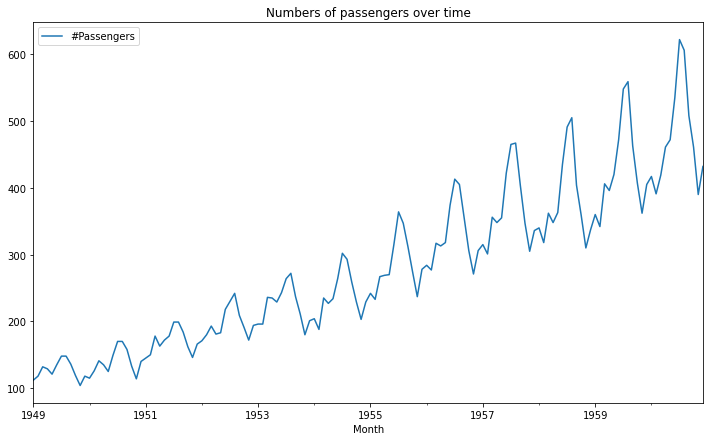

In [12]:
fig, ax = plt.subplots(figsize=(12,7))

data.plot(ax=ax)

ax.set_title('Numbers of passengers over time')
plt.legend(loc=0)

plt.show()

We can see that this serie has a positive trend and a seaonality (yearly).

## Split train test

To test our model we'll need a part of the data that is not used to be trained on. So let's take **20%** of the full dataset.

**The test set has to be after the train set.** 

In [13]:
test_size = 0.2

y = data['#Passengers'].sort_index(ascending=True)

split_idx = int(len(y) * (1-test_size))

y_train = y.iloc[:split_idx]
y_test = y.iloc[split_idx:]

In [14]:
print('Y train max month:', y_train.index.max().strftime('%Y-%m'))
print('Y test min month:', y_test.index.min().strftime('%Y-%m'))
print('Y train length:', len(y_train))
print('Y test length:', len(y_test))

Y train max month: 1958-07
Y test min month: 1958-08
Y train length: 115
Y test length: 29


## Is the variable stationary ?

We want to know if the variable is **stationary** because ARIMA and SARIMA models need inputs to be **stationary**.

**Definition :** A variable is stationary if statisticals properties like mean, variance or covariance are constant over time.

To find out this information we can use decomposition method from the statsmodel package. This method allows us to visualize **seasonality** (which can be daily, weekly, monthly, yearly), **trend** (Upward & downward movement) and **noise** (Spikes & troughs at random intervals).



In [15]:
def plot_decomposition(ts):
    """
    """
    decomposition = seasonal_decompose(ts)

    # Récupération de la tendance, saisonalité et du bruit de l'objet décomposé
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    # Affichage des différentes infos
    fig, axes = plt.subplots(4, 1, figsize=(15,12))

    ax = axes[0]
    ax.plot(ts, label='Original')
    ax.legend(loc=0)

    ax = axes[1]
    ax.plot(trend, label='Trend')
    ax.legend(loc=0)

    ax = axes[2]
    ax.plot(seasonal, label='Seasonality')
    ax.legend(loc=0)

    ax = axes[3]
    ax.plot(residual, label='Noise')
    ax.legend(loc=0)

    plt.tight_layout()
    plt.show()

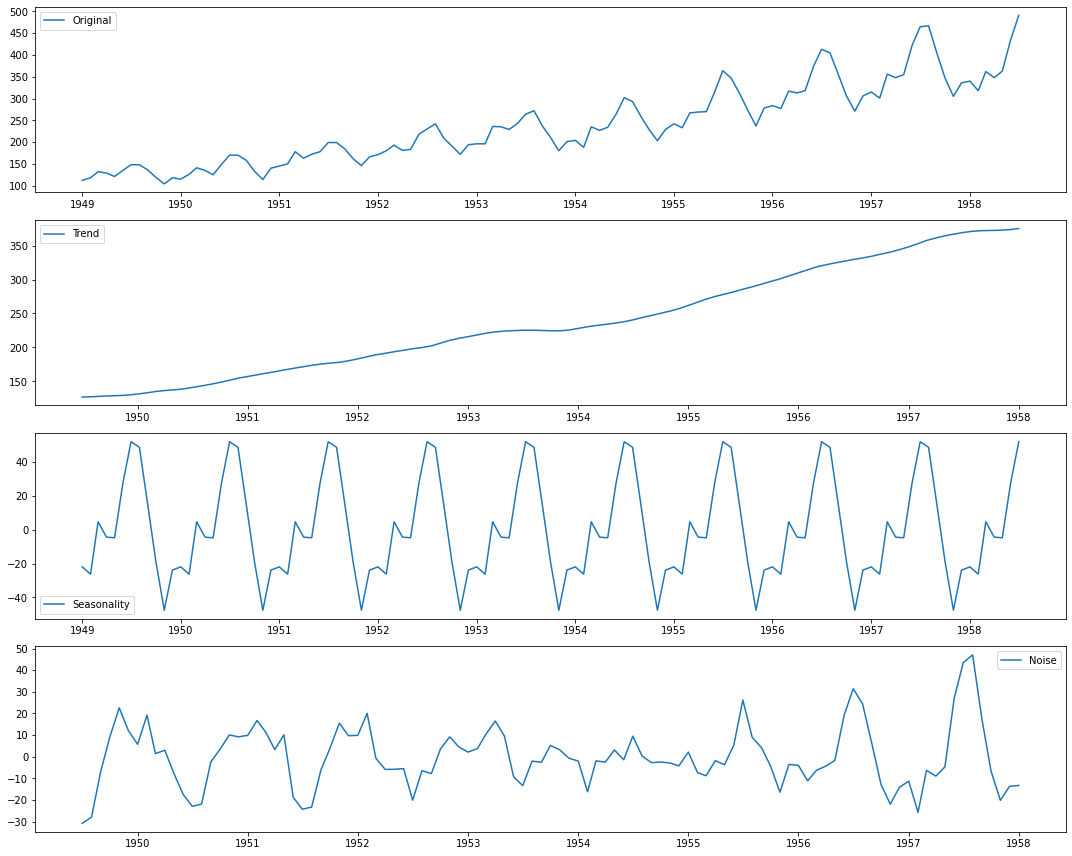

In [16]:
plot_decomposition(y_train)

We observe that :
- There is an upward trend as well as seasonality, which implies that the series is not stationary. 
- Seasonality is annual (the curve follows the same shape every year)

Statistical test: To confirm our visual observation on the plot above, we will use [the Dickey-Fuller hypothesis test](https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test).

- **Null hypothesis :** The series is not stationary.
- **Alternative hypothesis** : The series is stationary.

In [17]:
from statsmodels.tsa.stattools import adfuller

def analyse_time_series(ts):
    """
    """
    # Computes rolling stats  
    rolmean = ts.rolling(window=8, center=False).mean()
    rolstd = ts.rolling(window=8, center=False).std()

    # Dickey Fuller's test
    dftest = adfuller(ts)

    fig, ax = plt.subplots(figsize=(10,6))
    ax.plot(ts, label='Original')
    ax.plot(rolmean, label='Rolling mean (8 days)')
    ax.plot(rolstd, label='Rolling std (8 days)')
    plt.legend(loc=0)
    plt.title('Rolling mean and std (8 days)')
    plt.show()

    # Print test's result
    print('Dickey Fuller test results')
    print('ADF Statistic: {}'.format(dftest[0]))
    print('p-value: {}'.format(dftest[1]))
    print('Critical Values:')
    for key, value in dftest[4].items():
        print('\t{}: {}'.format(key, value))

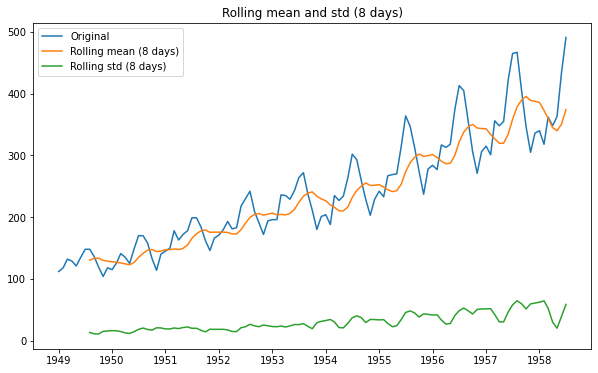

Dickey Fuller test results
ADF Statistic: -0.3568892196404638
p-value: 0.9170517285875908
Critical Values:
	1%: -3.4968181663902103
	5%: -2.8906107514600103
	10%: -2.5822770483285953


In [18]:
analyse_time_series(ts=y_train)

With a P-value of $0.91$, we failed to reject the null hypothesis and the rolling statistics (mean and std) do not seem to be constant so to transform this serie as a stationary variable we can use some function such as the difference from n days, log transformation and others.

Here we'll use log first and difference transformation. (Difference is part of the ARIMA and SARIMA models)

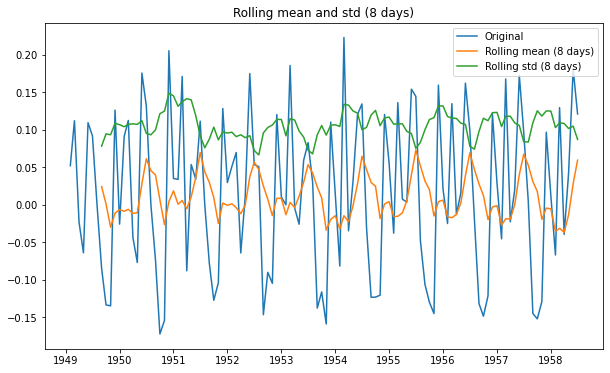

Dickey Fuller test results
ADF Statistic: -2.6358514279437615
p-value: 0.0858115465058254
Critical Values:
	1%: -3.4968181663902103
	5%: -2.8906107514600103
	10%: -2.5822770483285953


In [19]:
y_train_log = np.log(y_train)
y_train_diff = y_train_log.diff(1).dropna()

analyse_time_series(y_train_diff)

Now with a p-value under 10% it's better to use our models. We just need to remember that we use log transformation.

In [55]:
y_test_log = np.log(y_test)

## What is ARIMA and SARIMA ? 

### How works ARIMA and SARIMA ?

#### ARIMA

An ARIMA model is composed of 3 units which are :

- **AR: Autoregression**. This part explores any dependent relationship between an observation and some number of lagged variables. It is determined by $p$ parameter.

$$y_t = \beta_1 y_{t-1} + \beta_2 y_{t-2} + \text{...} + \beta_p y_{t-p}$$

- **I: Integrated**. This part aims to make time-series stationery by subtracting or differencing an observation from observation at the previous time step of the same time series. It is defined by $d$ parameter. 

$$y_t = (y_t - y_{t-1}) - (y_{t-1} - y_{t-2}) - \text{...} - (y_{t-d+1} - y_{t-d})$$

`statsmodels.tsa.arima_model.ARIMA` handle a maximum value of $d=2$.

- **MA: Moving Average**. This part explores the relationship between an observation and a residual error by application of moving average to lagged observations, with any given time window. It is define by $q$ parameter.

$$y_t = \epsilon_{t} + \alpha_{1}\epsilon_{t-1} + \alpha_{2}\epsilon_{t-2} + \text{...} + \alpha_{q}\epsilon_{t-q} $$

The 3 differents hyperparameters for an ARIMA model are :

- **p:** The number of lag observations included in the model, also called the lag order.
- **d:** The number of times that the raw observations are differenced also called the degree of difference.
- **q:** The size or the order of the moving average window.

ARIMA model is noted as the following : $\text{ARIMA}(p,d,q)$. So $\text{ARIMA}(2,1,2)$ means that $p=2$ for AR part, $d=1$ for I part and $q=2$ for MA part.

So ARIMA combine this different formula as one. If your variable is already stationary, you can use ARMA model (or $\text{ARIMA}(p,0,q)$).

#### SARIMA

Now, like in our case, some timeseries has a seasonal property.

In this case we can use **SARIMA** model. It's exactly the same except we add a seasonal part. 
It follows this definition : $\text{SARIMA}(p,d,q)(P,D,Q)_m$

Where :

- $m$ is the seasonnality (7 if weekly, 12 if yearly, etc.)
- $P$ is the Seasonal AR order : so it's the same as $p$ except the lagged version become $t - (n \times m)$
- $D$ is the Seasonal difference order : so it's the same as $d$ except the lagged version become $t - (n \times m)$
- $Q$ is the Seasonal MA order : so it's the same as $q$ except the lagged version become $t - (n \times m)$


*Sources :* 
- https://hackernoon.com/basic-understanding-of-arimasarima-vs-auto-arimasarima-using-covid-19-data-predicions-8o1v3x4t
- https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7



#### Choosing ARIMA or SARIMA ?

The main difference is the seasonnality. I recommend using SARIMA if your data have some seasonality.

You can solve teh seasonal problem with 2 solutions :

1. Using ARIMA but using seasonal differencing it consists to transform $y$ as the following : $y_t^\prime = y_t - y_{t-m}$  
2. Using SARIMA with $m = \text{season order}$ 

*Source :*
- https://stats.stackexchange.com/questions/413176/arima-vs-sarima



In [20]:
# You can import SARIMA and ARIMA in Python with this
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX



#### Order selection

We can determine the orders by using differents methods : 

- The Box-Jenkins Method
- Random or Grid search with an opitimization criteria

##### The Box-Jenkins Method

Definition found on the [NCSS TheBox-Jenkins Method article](https://ncss-wpengine.netdna-ssl.com/wp-content/themes/ncss/pdf/Procedures/NCSS/The_Box-Jenkins_Method.pdf)

The Box-Jenkins method refers to the iterative application of the following three steps:

1. **Identification**: Using plots of the data, autocorrelations, partial autocorrelations, and other information, a class of simple ARIMA models is selected. This amounts to estimating appropriate values for p, d, and q.
2. **Estimation**: The parameters of the selected model are estimated using maximum likelihood techniques, backcasting, etc., as outlined in Box-Jenkins (1976).
3. **Diagnostic Checking**: The fitted model is checked for inadequacies by considering the autocorrelations of the residual series (the series of residual, or error, values).

These steps are applied iteratively until step three does not produce any improvement in the model. 

So we use Auto Correlation Function (ACF) and Partial Auto Correlation Function (PACF) to determine $p$, $d$ and $q$. 

*Auto Correlation Function (ACF)*:

The correlation between the observations at the current point in time and the observations at all previous points in time. We can use ACF to determine the optimal number of MA terms. The number of terms determines the order of the model.

*Partial Auto Correlation Function (PACF)*:

As the name implies, PACF is a subset of ACF. PACF expresses the correlation between observations made at two points in time while accounting for any influence from other data points. We can use PACF to determine the optimal number of terms to use in the AR model. The number of terms determines the order of the model.

**Determine d**:

The level of differencing is estimated by considering the autocorrelation plots. When the autocorrelations die out quickly, the appropriate value of d has been found.

**Determine p**:

The value of p is determined from the partial autocorrelations of the appropriately differenced series. If the partial autocorrelations cut off after a few lags, the last lag with a large value would be the estimated value of p.

**Determine q**:

The value of q is found from the autocorrelations of the appropriately differenced series. If the autocorrelations cut off after a few lags, the last lag with a large value would be the estimated value of q. 

----

So let's try this method in Python

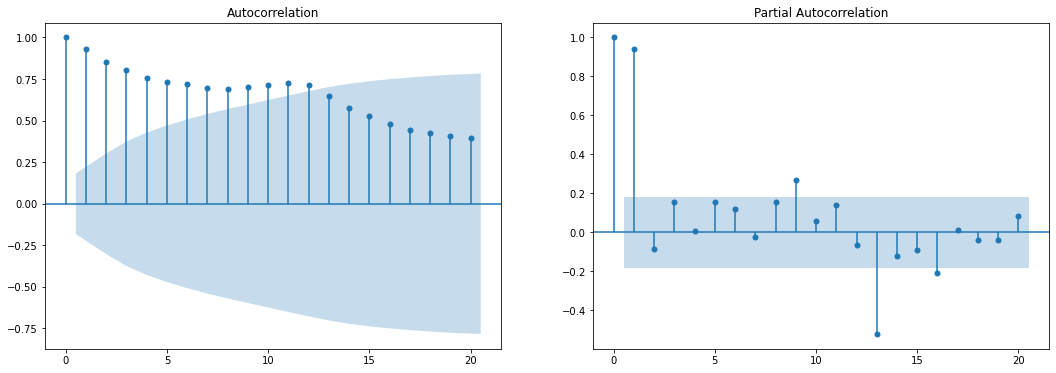

In [29]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_acf_pacf(y, lags=20):
    fig, axes = plt.subplots(1, 2, figsize=(18,6))
    plot_acf(y, lags=lags, ax=axes[0])

    plot_pacf(y, lags=lags, ax=axes[1])
    plt.show()
    
plot_acf_pacf(y_train_log)

Notice that the autocorrelations do not die out and they show a cyclical pattern. This points to nonstationarity in the data. The partial autocorrelations point to a value of 1 for p. However, because of the obvious nonstationarity, we first want to look at the autocorrelation functions of the first differences. Because these are monthly data, we use seasonal differences of length twelve. We also remove the trend in the data.

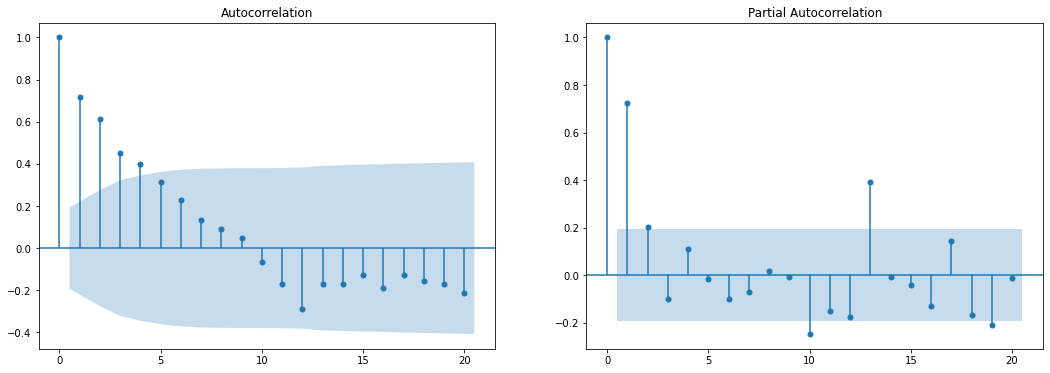

In [32]:
y_train_diff_12 = y_train_log.diff(12).dropna()

plot_acf_pacf(y_train_diff_12)

The autocorrelations die out fairly quickly. The partial autocorrelations shows that it dies quickly just after 1 so $P=1$ but the auto-correlation do not die quickly so $Q=0$. This suggests a SARIMA model : $\text{SARIMA}(1,0,0)(1,1,0)_{12}$

In [108]:
order = (1,0,0)
seasonal_order = (1,1,0,12)

# SARIMAX doc : https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html
model_bk_method = SARIMAX(y_train_log,
                            order=order,
                            seasonal_order=seasonal_order,
                            enforce_stationarity=False,
                            enforce_invertibility=False
                           )

In [109]:
model_bk_method = model_bk_method.fit()

In [110]:
model_bk_method.summary().tables[0]

Dep. Variable:,#Passengers,No. Observations:,115
Model:,"SARIMAX(1, 0, 0)x(1, 1, 0, 12)",Log Likelihood,159.106
Date:,"Mon, 16 Nov 2020",AIC,-312.212
Time:,12:06:34,BIC,-304.712
Sample:,01-01-1949,HQIC,-309.187
,- 07-01-1958,,
Covariance Type:,opg,,


In [60]:
model_bk_method.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.9711,0.021,46.400,0.000,0.930,1.012
ar.S.L12,-0.4307,0.074,-5.803,0.000,-0.576,-0.285
sigma2,0.0017,0.000,7.486,0.000,0.001,0.002


In [75]:
def plot_sarima_forecast(model, y_train, y_test=None, max_date=None):
    """
    """
    if (y_test is None) & (max_date is None):
        raise ValueError('y_test or max_date has to be set')
    
    # Change max_date if y_test is set
    if y_test is not None:
        max_date_test = y_test.index.max()
        
        if max_date is not None:
            if max_date < max_date_test:
                max_date = max_date_test
        else:
            max_date = max_date_test
    
    # Forecast
    forecast_values = model.get_forecast(max_date)
    forecast_ci = forecast_values.conf_int()
    
    # init plot 
    fig, ax = plt.subplots(figsize=(11,6))
    
    # Plot train
    y_train.plot(ax=ax, label='train')
    
    if y_test is not None:
        y_test.plot(ax=ax, label='test')

    # Plot forecasts values
    forecast_values.predicted_mean.plot(ax=ax, label='forecast')

    # Plot the confidence intervals
    ax.fill_between(forecast_ci.index,
                    forecast_ci.iloc[:,0],
                    forecast_ci.iloc[:,1], color='g', alpha=0.2)


    ax.set_xlabel('Date')
    ax.set_ylabel('Target')

    plt.legend()
    plt.grid()
    plt.show()

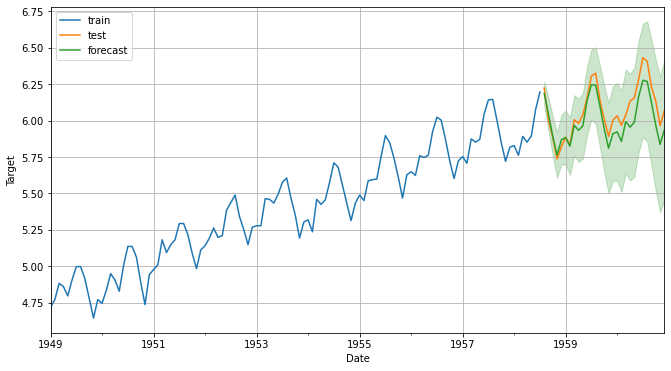

In [76]:
plot_sarima_forecast(model_bk_method, y_train_log, y_test_log)

Also we can compute the model's score : **AIC**, **BIC** and **RMSE**

In [77]:
from sklearn.metrics import mean_squared_error

def sarima_predict(model, y_test):
    """
    """
    max_date = y_test.index.max()
    y_pred = model.get_forecast(max_date).predicted_mean
    
    return y_pred

In [111]:
# Get predictions
y_pred = sarima_predict(model_bk_method, y_test_log)

# Compute RMSE
rmse = mean_squared_error(y_test_log, y_pred, squared=False)

# Create DataFrame with details
details = [order, seasonal_order, output.aic, output.bic, rmse]
columns = ['pdq', 'PDQS', 'AIC', 'BIC','RMSE']    
model_df = pd.DataFrame([details], columns=columns, index=['Box-Jenkins Method'])

In [112]:
model_df

,pdq,PDQS,AIC,BIC,RMSE
Box-Jenkins Method,"(1, 0, 0)","(1, 1, 0, 12)",-312.211515,-304.712086,0.095609



##### With an opitimization criteria

We can use this differents criterias to determine the best orders :

1. Akaike information criterion (AIC) 

$$ \text{AIC} = -2\log{L} + 2(p+q+k) $$

Where L is the likelihood of the data, p is the order of the autoregressive part and q is the order of the moving average part. The k represents the intercept of the ARIMA model. For AIC, if k = 1 then there is an intercept in the ARIMA model (c ≠ 0) and if k = 0 then there is no intercept in the ARIMA model (c = 0).

2. The corrected AIC for ARIMA (AICc)

$$ \text{AIC}_c = \text{AIC} + \frac{2(p+q+k)(p+q+k+1)}{T-p-q-k-1} $$

3. The Bayesian Information Criterion (BIC)

$$ \text{BIC} = \text{AIC} + ((\log T)-2)(p+q+k)$$

4. Root Mean Square Error (RMSE)

$$ \text{RMSE} = \sqrt{\frac{1}{T}\sum_{t-1}^T(x_t - \hat{x}_t)^2} $$


*Sources :*

- https://www.wikiwand.com/en/Autoregressive_integrated_moving_average#/Differencing

--- 

We can not use `GridSearchCV` from `sklearn` package because this model has not the same logic (only $y$ not $X$)

So I created a custom function : **it does not support Cross validation** (You can update this function to add it)

In [100]:
import itertools 
import gc

def grid_search_sarima(pqd, PQDS, y_train, y_test=None):
    """
    """
    models = list()
    if y_test is not None:
        max_date = y_test.index.max()
        
    for (order, seasonal_order) in itertools.product(pdq, PDQS):
        gc.collect()

        # Some combination can not be computed 
        try:
            model = SARIMAX(y_train,
                            order=order,
                            seasonal_order=seasonal_order,
                            enforce_stationarity=False,
                            enforce_invertibility=False
                           )

            model = model.fit()
            details = [model, order, seasonal_order, model.aic, model.bic]
            
            # Add RMSE score if y_test is available
            if y_test is not None:
                y_pred = sarima_predict(model, y_test)
                rmse = mean_squared_error(y_test, y_pred, squared=False)
                
                details += [rmse]
            
            models.append(details)

            del model, output
            
        except:
            continue
    
    cols = ['model', 'pdq', 'PDQS', 'AIC', 'BIC']    
    if y_test is not None:
        cols += ['RMSE']
    
    models_df = pd.DataFrame(models, columns=cols)
    
    return models_df

In [101]:
%%time
# Ordre p, d, q pour ARIMA
p = [0,1]; d = [0,1]; q = [0,1]

# Ordre P, D, Q pour SARIMA
P = [0,1,2]; D = [0,1]; Q = [0,1,2]; S = [0,12]

# génération des combinaisons pour p d et q
pdq = list(itertools.product(p, d, q))

# génération des combinaisons pour P D Q et S
PDQS = list(itertools.product(P, D, Q, S))

models_df = grid_search_sarima(pdq, 
                               PDQS, 
                               y_train=y_train_log, 
                               y_test=y_test_log)

Wall time: 2min 20s


In [102]:
best_aic = models_df.sort_values(by='AIC', ascending=True).head()
best_bic = models_df.sort_values(by='BIC', ascending=True).head()
best_rmse = models_df.sort_values(by='RMSE', ascending=True).head()

In [114]:
best_aic.iloc[:,1:]

,pdq,PDQS,AIC,BIC,RMSE
84,"(1, 0, 0)","(1, 0, 1, 12)",-368.656461,-358.156570,0.112738
103,"(1, 0, 1)","(1, 0, 1, 12)",-366.560063,-353.484461,0.082662
122,"(1, 1, 0)","(1, 0, 1, 12)",-365.257865,-354.797383,0.033395
65,"(0, 1, 1)","(1, 0, 1, 12)",-361.176412,-350.755732,0.033627
46,"(0, 1, 0)","(1, 0, 1, 12)",-358.982320,-351.136959,0.036985


In [115]:
best_bic.iloc[:,1:]

,pdq,PDQS,AIC,BIC,RMSE
84,"(1, 0, 0)","(1, 0, 1, 12)",-368.656461,-358.156570,0.112738
122,"(1, 1, 0)","(1, 0, 1, 12)",-365.257865,-354.797383,0.033395
103,"(1, 0, 1)","(1, 0, 1, 12)",-366.560063,-353.484461,0.082662
46,"(0, 1, 0)","(1, 0, 1, 12)",-358.982320,-351.136959,0.036985
65,"(0, 1, 1)","(1, 0, 1, 12)",-361.176412,-350.755732,0.033627


In [116]:
best_rmse.iloc[:,1:]

,pdq,PDQS,AIC,BIC,RMSE
122,"(1, 1, 0)","(1, 0, 1, 12)",-365.257865,-354.797383,0.033395
65,"(0, 1, 1)","(1, 0, 1, 12)",-361.176412,-350.755732,0.033627
141,"(1, 1, 1)","(1, 0, 1, 12)",-358.925042,-345.899191,0.033807
49,"(0, 1, 0)","(1, 1, 1, 12)",-310.592864,-303.126955,0.034060
119,"(1, 1, 0)","(0, 1, 1, 12)",-327.466106,-320.000197,0.034140


With this method we can that the best method is the $\text{SARIMA}(1,1,0)(1,0,1)_{12}$ model.

In [125]:
model_gridsearch = best_rmse.iloc[0]
model_gridsearch = model_gridsearch.to_frame().T

gridsearch_details = model_gridsearch.drop(columns='model')
gridsearch_details.index = ['GridSearch method']

model_gridsearch = model_gridsearch['model'].iloc[0]

In [129]:
model_df = pd.concat([model_df, gridsearch_details])

In [130]:
model_df

,pdq,PDQS,AIC,BIC,RMSE
Box-Jenkins Method,"(1, 0, 0)","(1, 1, 0, 12)",-312.212,-304.712,0.0956092
GridSearch method,"(1, 1, 0)","(1, 0, 1, 12)",-365.258,-354.797,0.033395


So it seems that the GridSearch model has best score which is not surprising because we want to minimize the score criteria. 

(If we take the SARIMA model with the best AIC and BIC performance, the RMSE score is greater than for the Box Jenkins model)

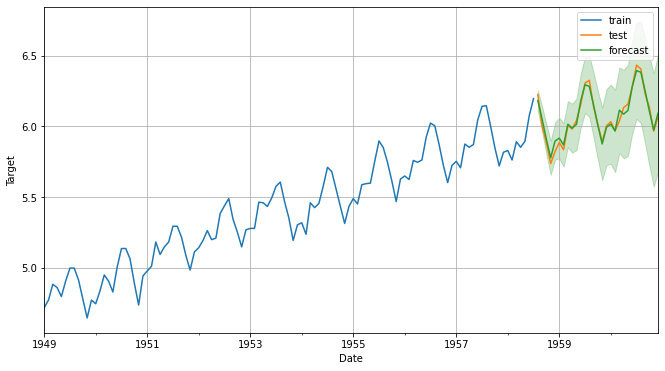

In [131]:
plot_sarima_forecast(model_gridsearch, y_train_log, y_test_log)

**As we can see it fit almost perfectly the test set !**

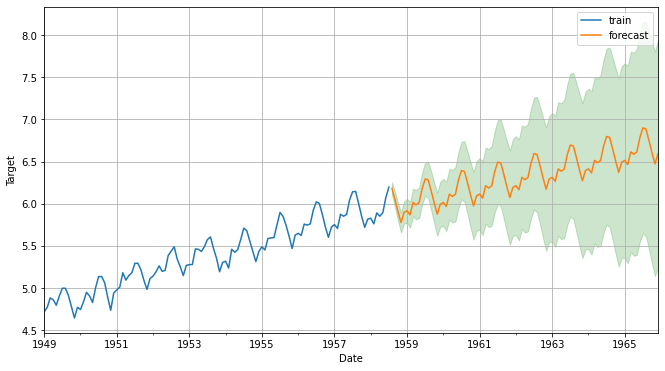

In [133]:
import datetime

max_date = datetime.datetime(1965,12,1)

plot_sarima_forecast(model_gridsearch, y_train_log, max_date=max_date)

Thanks for reading.

$\text{Nathan}$